In [1]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Datos de entrenamiento

1. `(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()`: Carga el conjunto de datos MNIST, dividiéndolo en imágenes y etiquetas de entrenamiento. El segundo conjunto (de prueba) no se utiliza, por eso se ignora con `_`.

2. `train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')`: Redimensiona las imágenes de entrenamiento para que tengan un formato de 28x28 píxeles con 1 canal (escala de grises) y convierte los valores a tipo `float32`.

3. `train_images = (train_images - 127.5) / 127.5`: Normaliza los valores de los píxeles, que originalmente están entre 0 y 255, para que queden en el rango [-1, 1]. Esto es importante para mejorar el rendimiento de las redes neuronales, especialmente cuando se usan activaciones como `tanh`, que esperan entradas en este rango.

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128

Este código crea un conjunto de datos (`train_dataset`) a partir de las imágenes de entrenamiento (`train_images`). Utiliza la función `from_tensor_slices` para convertir el array de imágenes en un formato compatible con TensorFlow, y luego aplica dos operaciones:

1. `shuffle(BUFFER_SIZE)`: Desordena aleatoriamente las imágenes utilizando un tamaño de buffer especificado por `BUFFER_SIZE`, lo que ayuda a mezclar los datos antes del entrenamiento.
2. `batch(BATCH_SIZE)`: Agrupa las imágenes en lotes del tamaño `BATCH_SIZE`, lo que permite que el modelo entrene en pequeños subconjuntos de datos en cada iteración.

Esto organiza las imágenes de entrenamiento para ser usadas de manera eficiente en el proceso de entrenamiento del modelo.

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2024-10-04 15:29:02.091001: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-04 15:29:02.091023: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-04 15:29:02.091032: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-04 15:29:02.091048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-04 15:29:02.091061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


El generador toma un vector de 100 números aleatorios como entrada y lo transforma en una imagen de 28x28 píxeles. Usa capas densas, BatchNormalizatio), activación LeakyReLU, y varias capas Conv2DTranspose para aumentar el tamaño de la imagen gradualmente hasta obtener la salida final, que tiene una única capa de profundidad y usa la activación tanh para generar la imagen final.

## Generador Ligero
---
1. Unidades reducidas en la capa densa: las unidades de la primera capa densa se redujeron de 7×7×256 (12544) a 7×7×128 (6272). Menos unidades significan menos pesos para entrenar, lo que reduce la complejidad computacional durante los pases hacia adelante y hacia atrás.
2. Filtros reducidos en las capas Conv2DTranspose: se redujo la cantidad de filtros en cada capa Conv2DTranspose (por ejemplo, de 128 a 64 y de 64 a 32). Esto reduce directamente la cantidad de parámetros y cálculos por capa, al mismo tiempo que permite que el modelo genere resultados complejos.
3. Estructura clave mantenida: si bien se redujo la complejidad del modelo, se mantiene la estructura general para garantizar que el modelo aún tenga un buen desempeño en la generación de datos, incluso con menos parámetros.

In [6]:
def make_generator_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100,)))  # Reduced units from 256 to 128
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))  # Adjusted the reshape layer to match reduced filters

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))  # Reduced filters
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))  # Reduced filters
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

/Users/gustavogonzalez/miniconda3/envs/lab3_ia/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


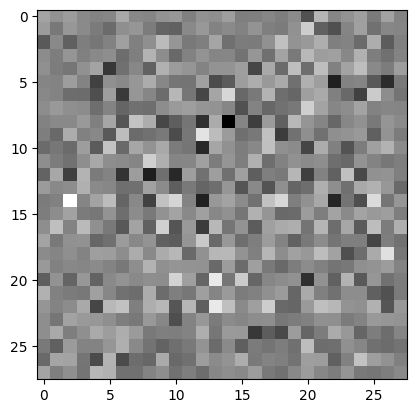

In [7]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

El discriminador toma una imagen de 28x28 píxeles como entrada y la procesa a través de capas convolucionales. Utiliza capas de `Dropout` para prevenir el sobreajuste y reduce la dimensionalidad de la imagen con una capa `Flatten`. Finalmente, una capa densa con una única salida determina si la imagen es real o generada por el modelo, proporcionando una probabilidad.

## Discriminador Ligero
---
1. Filtros reducidos en las capas Conv2D: la cantidad de filtros se redujo de 64 a 32 en la primera capa y de 128 a 64 en la segunda capa. Esto disminuye la cantidad de operaciones de convolución y parámetros, lo que reduce significativamente el tiempo de cálculo.
2. Núcleos más pequeños en la segunda capa: el tamaño del núcleo en la segunda capa convolucional se redujo de (5, 5) a (3, 3). Los núcleos más pequeños son menos costosos computacionalmente porque requieren menos multiplicaciones, lo que acelera el paso hacia adelante.
3. Se mantuvieron las capas Densa y Dropout: estas capas ya son eficientes y las capas Dropout ayudan a prevenir el sobreajuste con un recuento de parámetros menor. Mantener la capa de salida Densa(1) es necesario para la clasificación binaria (real o falsa).

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))  # Reduced filters
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))  # Reduced filters
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.01086946]], shape=(1, 1), dtype=float32)


/Users/gustavogonzalez/miniconda3/envs/lab3_ia/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

1. `real_loss`: Calcula la pérdida del discriminador al clasificar imágenes reales. Compara las salidas del discriminador (`real_output`) con un conjunto de etiquetas de unos (porque las imágenes reales deberían clasificarse como "reales"). Se utiliza la función de pérdida de entropía cruzada (`cross_entropy`) para esta comparación.

2. `fake_loss`: Calcula la pérdida del discriminador al clasificar imágenes generadas (falsas). Compara las salidas del discriminador (`fake_output`) con etiquetas de ceros (porque las imágenes generadas deberían clasificarse como "falsas").

3. `total_loss`: Suma las pérdidas de las imágenes reales y generadas para obtener la pérdida total del discriminador.

El objetivo es minimizar esta pérdida, de modo que el discriminador mejore en clasificar imágenes reales como reales y falsas como falsas.

In [11]:
def discriminator_loss(real_output, fake_output):
    # LSGAN
    # Real samples should have output close to 1, fake samples close to 0
    real_loss = tf.reduce_mean(tf.square(real_output - 1))
    fake_loss = tf.reduce_mean(tf.square(fake_output))
    return real_loss + fake_loss

Esta función define la pérdida del generador. El objetivo del generador es crear imágenes falsas que engañen al discriminador haciéndole creer que son reales.

1. `fake_output`: Es la salida del discriminador al clasificar las imágenes generadas por el generador.

2. `cross_entropy(tf.ones_like(fake_output), fake_output)`: Calcula la pérdida del generador comparando las salidas del discriminador (`fake_output`) con un conjunto de etiquetas de unos (porque el generador quiere que el discriminador clasifique las imágenes falsas como "reales"). Se utiliza la función de entropía cruzada para medir qué tan bien está logrando esto.

El generador trata de minimizar esta pérdida, de modo que el discriminador no pueda diferenciar entre las imágenes reales y las generadas.

In [12]:
def generator_loss(fake_output):
    # LSGAN
    # Generator wants to make discriminator output close to 1
    return tf.reduce_mean(tf.square(fake_output - 1))

In [13]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

La anotación `@tf.function` optimiza la función compilándola para que sea más rápida.

1. **Generación de ruido**: Se crea un vector de ruido aleatorio con dimensiones `[BATCH_SIZE, noise_dim]` para alimentar al generador.

2. **GradientTape**: `
   - Se utilizan dos tf.GradientTape`, uno para el generador (`gen_tape`) y otro para el discriminador (`disc_tape`). Esto permite calcular los gradientes para ambos modelos.
   
3. **Generación de imágenes**: El generador usa el ruido para generar imágenes falsas (`generated_images`).

4. **Evaluación del discriminador**:
   - `real_output`: El discriminador procesa las imágenes reales y devuelve una clasificación.
   - `fake_output`: El discriminador evalúa las imágenes generadas y también devuelve una clasificación.

5. **Cálculo de pérdidas**:
   - `gen_loss`: Pérdida del generador, basada en qué tan bien las imágenes generadas engañan al discriminador.
   - `disc_loss`: Pérdida del discriminador, basada en su capacidad para diferenciar entre imágenes reales y generadas.

6. **Cálculo de gradientes**:
   - Se calculan los gradientes de la pérdida con respecto a los pesos entrenables del generador y el discriminador.

7. **Actualización de los modelos**:
   - `generator_optimizer.apply_gradients`: Aplica los gradientes calculados para actualizar los pesos del generador.
   - `discriminator_optimizer.apply_gradients`: Hace lo mismo para el discriminador.

En resumen, este bloque realiza un paso completo de entrenamiento, ajustando tanto el generador como el discriminador para que ambos mejoren en sus respectivos objetivos (engañar o no ser engañado).

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return the generator and discriminator loss for tracking
    return gen_loss, disc_loss


In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


1. **Inicio del bucle de épocas**:
   - El entrenamiento se repite por la cantidad de épocas definida en el argumento `epochs`.
   - Al inicio de cada época, se registra el tiempo con `start = time.time()` para medir cuánto tarda cada una.

2. **Entrenamiento por lotes**:
   - Dentro de cada época, se itera sobre cada lote de imágenes del conjunto de datos (`dataset`), llamando a la función `train_step(image_batch)` para entrenar el generador y discriminador en ese lote.

3. **Generación de imágenes**:
   - Se genera y guarda una imagen utilizando la función `generate_and_save_images(generator, epoch + 1, seed)`, donde el generador crea nuevas imágenes a partir de una semilla (`seed`), permitiendo un seguimiento visual del progreso de la GAN.

4. **Medición del tiempo**:
   - Se calcula y muestra el tiempo que tomó completar cada época con `print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))`.

5. **Generación final**:
   - Después de la última época, se genera una imagen final con el mismo método de visualización.

En resumen, esta función coordina el entrenamiento de la GAN durante múltiples épocas, mide el tiempo por cada una y genera imágenes en cada iteración para ver cómo mejora la calidad de las imágenes generadas.

In [16]:
# Initialize lists to track losses
generator_losses = []
discriminator_losses = []
avg_gen_losses = []
avg_disc_losses = []

def train(dataset, epochs):
  for epoch in range(epochs):
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0
    start = time.time()

    for image_batch in dataset:
      d_loss, g_loss = train_step(image_batch)

      # Append losses to the lists
      discriminator_losses.append(d_loss)
      generator_losses.append(g_loss)

      # Accumulate losses for the epoch
      total_gen_loss += g_loss
      total_disc_loss += d_loss
      num_batches += 1

    # Compute average losses for the epoch
    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches

    avg_gen_losses.append(avg_gen_loss)
    avg_disc_losses.append(avg_disc_loss)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    if epoch % 10 == 0:
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(f'Epoch {epoch}, Average Discriminator Loss: {avg_disc_loss}, Average Generator Loss: {avg_gen_loss}')

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


2024-10-04 15:29:03.140083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-10-04 15:29:18.270624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


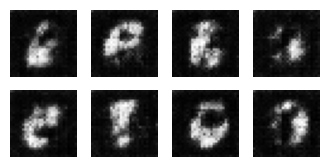

Time for epoch 1 is 15.764890193939209 sec
Epoch 0, Average Discriminator Loss: 0.5596023201942444, Average Generator Loss: 0.16741925477981567


2024-10-04 15:29:30.678275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 2 is 12.269301176071167 sec
Epoch 1, Average Discriminator Loss: 0.4774717092514038, Average Generator Loss: 0.28406402468681335


2024-10-04 15:29:43.140874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 3 is 12.456049919128418 sec
Epoch 2, Average Discriminator Loss: 0.35237616300582886, Average Generator Loss: 0.43641743063926697


2024-10-04 15:29:55.321351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 4 is 12.176941633224487 sec
Epoch 3, Average Discriminator Loss: 0.2962348759174347, Average Generator Loss: 0.48648667335510254


2024-10-04 15:30:07.540066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 5 is 12.215747117996216 sec
Epoch 4, Average Discriminator Loss: 0.27319177985191345, Average Generator Loss: 0.5061082243919373


2024-10-04 15:30:19.678626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 6 is 12.135875940322876 sec
Epoch 5, Average Discriminator Loss: 0.2668086588382721, Average Generator Loss: 0.5065447688102722


2024-10-04 15:30:31.867947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 7 is 12.186017036437988 sec
Epoch 6, Average Discriminator Loss: 0.26233363151550293, Average Generator Loss: 0.508709728717804


2024-10-04 15:30:44.031644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 8 is 12.159177780151367 sec
Epoch 7, Average Discriminator Loss: 0.256462424993515, Average Generator Loss: 0.5134127736091614


2024-10-04 15:30:56.169448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 9 is 12.134728908538818 sec
Epoch 8, Average Discriminator Loss: 0.2555896043777466, Average Generator Loss: 0.509330153465271


2024-10-04 15:31:08.252926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 10 is 12.080188989639282 sec
Epoch 9, Average Discriminator Loss: 0.25608503818511963, Average Generator Loss: 0.5101186037063599


2024-10-04 15:31:20.290718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


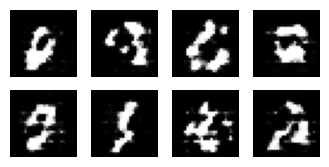

Time for epoch 11 is 12.09935474395752 sec
Epoch 10, Average Discriminator Loss: 0.2576759457588196, Average Generator Loss: 0.5084773302078247


2024-10-04 15:31:32.451479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 12 is 12.093950986862183 sec
Epoch 11, Average Discriminator Loss: 0.26099222898483276, Average Generator Loss: 0.5037002563476562


2024-10-04 15:31:44.551257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 13 is 12.096511840820312 sec
Epoch 12, Average Discriminator Loss: 0.2646208703517914, Average Generator Loss: 0.500645101070404


2024-10-04 15:31:56.679059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 14 is 12.122735977172852 sec
Epoch 13, Average Discriminator Loss: 0.260481595993042, Average Generator Loss: 0.505892813205719


2024-10-04 15:32:09.046707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 15 is 12.364768028259277 sec
Epoch 14, Average Discriminator Loss: 0.26094600558280945, Average Generator Loss: 0.503157377243042


2024-10-04 15:32:21.281099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 16 is 12.231906175613403 sec
Epoch 15, Average Discriminator Loss: 0.2639029920101166, Average Generator Loss: 0.5009496808052063


2024-10-04 15:32:33.256379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 17 is 11.972900152206421 sec
Epoch 16, Average Discriminator Loss: 0.2622711658477783, Average Generator Loss: 0.5009358525276184


2024-10-04 15:32:45.846371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 18 is 12.585815906524658 sec
Epoch 17, Average Discriminator Loss: 0.2575279474258423, Average Generator Loss: 0.5057282447814941


2024-10-04 15:32:57.851087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 19 is 12.003057956695557 sec
Epoch 18, Average Discriminator Loss: 0.2555628716945648, Average Generator Loss: 0.5068789124488831


2024-10-04 15:33:10.919761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 20 is 13.0661940574646 sec
Epoch 19, Average Discriminator Loss: 0.2580876052379608, Average Generator Loss: 0.5008121132850647


2024-10-04 15:33:23.586339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


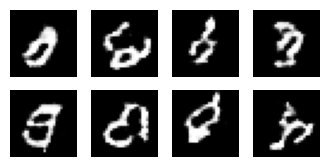

Time for epoch 21 is 12.754429817199707 sec
Epoch 20, Average Discriminator Loss: 0.2517440617084503, Average Generator Loss: 0.5086686015129089


2024-10-04 15:33:35.864010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 22 is 12.186378002166748 sec
Epoch 21, Average Discriminator Loss: 0.2509804368019104, Average Generator Loss: 0.507261335849762


2024-10-04 15:33:48.146227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 23 is 12.280661821365356 sec
Epoch 22, Average Discriminator Loss: 0.2518683969974518, Average Generator Loss: 0.5045361518859863


2024-10-04 15:34:00.398908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 24 is 12.250852108001709 sec
Epoch 23, Average Discriminator Loss: 0.2553790807723999, Average Generator Loss: 0.5011210441589355


2024-10-04 15:34:13.046806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 25 is 12.645999193191528 sec
Epoch 24, Average Discriminator Loss: 0.2575675845146179, Average Generator Loss: 0.5045737028121948


2024-10-04 15:34:25.771326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 26 is 12.722831010818481 sec
Epoch 25, Average Discriminator Loss: 0.26229310035705566, Average Generator Loss: 0.49625951051712036


2024-10-04 15:34:38.444084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 27 is 12.67095398902893 sec
Epoch 26, Average Discriminator Loss: 0.25913119316101074, Average Generator Loss: 0.49922195076942444


2024-10-04 15:34:51.583746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 28 is 13.138160228729248 sec
Epoch 27, Average Discriminator Loss: 0.2589735686779022, Average Generator Loss: 0.5008841753005981


2024-10-04 15:35:04.134690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 29 is 12.548679113388062 sec
Epoch 28, Average Discriminator Loss: 0.254670649766922, Average Generator Loss: 0.5053209662437439


2024-10-04 15:35:17.975802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 30 is 13.839452981948853 sec
Epoch 29, Average Discriminator Loss: 0.25335878133773804, Average Generator Loss: 0.5036810636520386


2024-10-04 15:35:30.836809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


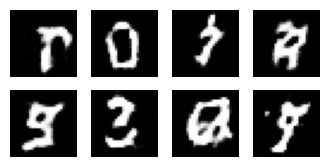

Time for epoch 31 is 12.934943199157715 sec
Epoch 30, Average Discriminator Loss: 0.25146669149398804, Average Generator Loss: 0.5039793848991394


2024-10-04 15:35:43.253890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 32 is 12.33938193321228 sec
Epoch 31, Average Discriminator Loss: 0.2520209848880768, Average Generator Loss: 0.5035155415534973


2024-10-04 15:35:55.813274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 33 is 12.557445049285889 sec
Epoch 32, Average Discriminator Loss: 0.2522094249725342, Average Generator Loss: 0.5030414462089539


2024-10-04 15:36:08.773110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 34 is 12.957144975662231 sec
Epoch 33, Average Discriminator Loss: 0.2548142969608307, Average Generator Loss: 0.5021670460700989


2024-10-04 15:36:21.987108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 35 is 13.212424278259277 sec
Epoch 34, Average Discriminator Loss: 0.26921895146369934, Average Generator Loss: 0.48869580030441284


2024-10-04 15:36:34.710928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 36 is 12.721969842910767 sec
Epoch 35, Average Discriminator Loss: 0.2699258625507355, Average Generator Loss: 0.4887003004550934


2024-10-04 15:36:47.294981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 37 is 12.58176302909851 sec
Epoch 36, Average Discriminator Loss: 0.26315373182296753, Average Generator Loss: 0.49371129274368286


2024-10-04 15:37:00.050261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 38 is 12.75297999382019 sec
Epoch 37, Average Discriminator Loss: 0.2591642439365387, Average Generator Loss: 0.49899259209632874


2024-10-04 15:37:12.903490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 39 is 12.851393938064575 sec
Epoch 38, Average Discriminator Loss: 0.2550044655799866, Average Generator Loss: 0.5030810236930847


2024-10-04 15:37:25.713341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 40 is 12.806443929672241 sec
Epoch 39, Average Discriminator Loss: 0.2518678307533264, Average Generator Loss: 0.5043593645095825


2024-10-04 15:37:38.865404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


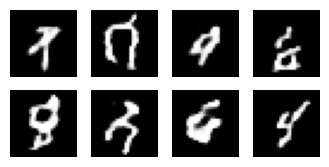

Time for epoch 41 is 13.227577924728394 sec
Epoch 40, Average Discriminator Loss: 0.25107502937316895, Average Generator Loss: 0.5043405890464783


2024-10-04 15:37:53.727942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 42 is 14.783414125442505 sec
Epoch 41, Average Discriminator Loss: 0.25140464305877686, Average Generator Loss: 0.5046847462654114


2024-10-04 15:38:07.239875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 43 is 13.510135889053345 sec
Epoch 42, Average Discriminator Loss: 0.25116655230522156, Average Generator Loss: 0.5034232139587402


2024-10-04 15:38:20.022540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 44 is 12.779195785522461 sec
Epoch 43, Average Discriminator Loss: 0.25163379311561584, Average Generator Loss: 0.5022029280662537


2024-10-04 15:38:33.023663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 45 is 12.99779725074768 sec
Epoch 44, Average Discriminator Loss: 0.25157445669174194, Average Generator Loss: 0.5020941495895386


2024-10-04 15:38:46.351995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 46 is 13.324800968170166 sec
Epoch 45, Average Discriminator Loss: 0.2508292496204376, Average Generator Loss: 0.5030707120895386


2024-10-04 15:39:00.016164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 47 is 13.662267684936523 sec
Epoch 46, Average Discriminator Loss: 0.25229525566101074, Average Generator Loss: 0.5015789270401001


2024-10-04 15:39:12.664802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 48 is 12.645409107208252 sec
Epoch 47, Average Discriminator Loss: 0.26150310039520264, Average Generator Loss: 0.49376946687698364


2024-10-04 15:39:25.024250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 49 is 12.357126235961914 sec
Epoch 48, Average Discriminator Loss: 0.2647469639778137, Average Generator Loss: 0.49438562989234924


2024-10-04 15:39:37.595830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 50 is 12.568850994110107 sec
Epoch 49, Average Discriminator Loss: 0.2653712332248688, Average Generator Loss: 0.489179402589798


2024-10-04 15:39:50.063088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


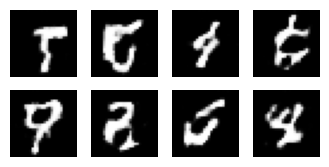

Time for epoch 51 is 12.53661298751831 sec
Epoch 50, Average Discriminator Loss: 0.2625916302204132, Average Generator Loss: 0.4967995584011078


2024-10-04 15:40:02.690070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 52 is 12.554728984832764 sec
Epoch 51, Average Discriminator Loss: 0.2545490264892578, Average Generator Loss: 0.5001547932624817


2024-10-04 15:40:15.169165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 53 is 12.476240158081055 sec
Epoch 52, Average Discriminator Loss: 0.2529328763484955, Average Generator Loss: 0.5029326677322388


2024-10-04 15:40:27.585860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 54 is 12.413846969604492 sec
Epoch 53, Average Discriminator Loss: 0.2510254383087158, Average Generator Loss: 0.503406822681427


2024-10-04 15:40:40.614036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 55 is 13.025450944900513 sec
Epoch 54, Average Discriminator Loss: 0.2509042024612427, Average Generator Loss: 0.5034839510917664


2024-10-04 15:40:53.536594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 56 is 12.920713901519775 sec
Epoch 55, Average Discriminator Loss: 0.2510560154914856, Average Generator Loss: 0.5027920603752136


2024-10-04 15:41:06.302436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 57 is 12.762930154800415 sec
Epoch 56, Average Discriminator Loss: 0.2504158616065979, Average Generator Loss: 0.5028159618377686


2024-10-04 15:41:18.924878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 58 is 12.62056279182434 sec
Epoch 57, Average Discriminator Loss: 0.2506333589553833, Average Generator Loss: 0.5022836327552795


2024-10-04 15:41:31.571531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 59 is 12.643974781036377 sec
Epoch 58, Average Discriminator Loss: 0.250358909368515, Average Generator Loss: 0.5026159286499023


2024-10-04 15:41:44.185868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 60 is 12.610414266586304 sec
Epoch 59, Average Discriminator Loss: 0.2505767047405243, Average Generator Loss: 0.5016184449195862


2024-10-04 15:41:56.639396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


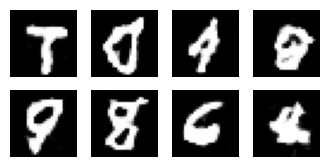

Time for epoch 61 is 12.526424169540405 sec
Epoch 60, Average Discriminator Loss: 0.2514669895172119, Average Generator Loss: 0.5008010268211365


2024-10-04 15:42:09.277127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 62 is 12.560488939285278 sec
Epoch 61, Average Discriminator Loss: 0.2658454477787018, Average Generator Loss: 0.4940148890018463


2024-10-04 15:42:21.816659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 63 is 12.537798881530762 sec
Epoch 62, Average Discriminator Loss: 0.26590901613235474, Average Generator Loss: 0.49227508902549744


2024-10-04 15:42:34.532083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 64 is 12.71337103843689 sec
Epoch 63, Average Discriminator Loss: 0.26051533222198486, Average Generator Loss: 0.4953823387622833


2024-10-04 15:42:47.805221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 65 is 13.270665168762207 sec
Epoch 64, Average Discriminator Loss: 0.2568432688713074, Average Generator Loss: 0.4967651665210724


2024-10-04 15:43:01.285530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 66 is 13.478291988372803 sec
Epoch 65, Average Discriminator Loss: 0.2544027268886566, Average Generator Loss: 0.5010105967521667


2024-10-04 15:43:14.808542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 67 is 13.520698070526123 sec
Epoch 66, Average Discriminator Loss: 0.25175169110298157, Average Generator Loss: 0.503003716468811


2024-10-04 15:43:28.293248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 68 is 13.483294010162354 sec
Epoch 67, Average Discriminator Loss: 0.2514663636684418, Average Generator Loss: 0.5018203854560852


2024-10-04 15:43:41.386991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 69 is 13.091193914413452 sec
Epoch 68, Average Discriminator Loss: 0.25057879090309143, Average Generator Loss: 0.5020669102668762


2024-10-04 15:43:54.441225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 70 is 13.05178689956665 sec
Epoch 69, Average Discriminator Loss: 0.25069913268089294, Average Generator Loss: 0.5016347765922546


2024-10-04 15:44:07.027757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


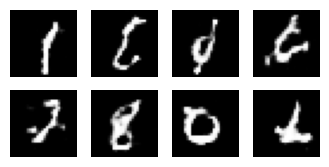

Time for epoch 71 is 12.653647899627686 sec
Epoch 70, Average Discriminator Loss: 0.25134527683258057, Average Generator Loss: 0.5011484026908875


2024-10-04 15:44:19.592953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 72 is 12.494258880615234 sec
Epoch 71, Average Discriminator Loss: 0.2593037486076355, Average Generator Loss: 0.4960152804851532


2024-10-04 15:44:32.263722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 73 is 12.667272806167603 sec
Epoch 72, Average Discriminator Loss: 0.26372241973876953, Average Generator Loss: 0.4937577247619629


2024-10-04 15:44:44.787294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 74 is 12.521217107772827 sec
Epoch 73, Average Discriminator Loss: 0.25836947560310364, Average Generator Loss: 0.49672192335128784


2024-10-04 15:44:57.397317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 75 is 12.6076819896698 sec
Epoch 74, Average Discriminator Loss: 0.2546245753765106, Average Generator Loss: 0.5005359053611755


2024-10-04 15:45:10.137273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 76 is 12.7376070022583 sec
Epoch 75, Average Discriminator Loss: 0.25339165329933167, Average Generator Loss: 0.499936580657959


2024-10-04 15:45:23.313947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 77 is 13.174229860305786 sec
Epoch 76, Average Discriminator Loss: 0.2519737482070923, Average Generator Loss: 0.5019304752349854


2024-10-04 15:45:36.813262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 78 is 13.496587991714478 sec
Epoch 77, Average Discriminator Loss: 0.2515627145767212, Average Generator Loss: 0.5015044212341309


2024-10-04 15:45:50.545960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 79 is 13.730259895324707 sec
Epoch 78, Average Discriminator Loss: 0.25136950612068176, Average Generator Loss: 0.5018858313560486


2024-10-04 15:46:04.219599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 80 is 13.670369863510132 sec
Epoch 79, Average Discriminator Loss: 0.25098729133605957, Average Generator Loss: 0.5016053318977356


2024-10-04 15:46:17.113999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


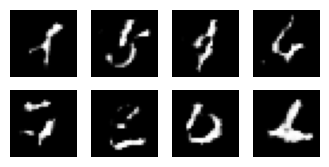

Time for epoch 81 is 12.965399742126465 sec
Epoch 80, Average Discriminator Loss: 0.2527204155921936, Average Generator Loss: 0.5006927847862244


2024-10-04 15:46:29.924656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 82 is 12.735636234283447 sec
Epoch 81, Average Discriminator Loss: 0.2619563937187195, Average Generator Loss: 0.49427685141563416


2024-10-04 15:46:43.058221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 83 is 13.13007402420044 sec
Epoch 82, Average Discriminator Loss: 0.2582419812679291, Average Generator Loss: 0.49830323457717896


2024-10-04 15:46:55.812443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 84 is 12.750916242599487 sec
Epoch 83, Average Discriminator Loss: 0.2518966794013977, Average Generator Loss: 0.5017215013504028


2024-10-04 15:47:09.534622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 85 is 13.719489097595215 sec
Epoch 84, Average Discriminator Loss: 0.2533531188964844, Average Generator Loss: 0.500117838382721


2024-10-04 15:47:25.110415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 86 is 15.572993755340576 sec
Epoch 85, Average Discriminator Loss: 0.2517665922641754, Average Generator Loss: 0.5011993646621704


2024-10-04 15:47:38.959859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 87 is 13.844505786895752 sec
Epoch 86, Average Discriminator Loss: 0.2513379454612732, Average Generator Loss: 0.5015653371810913


2024-10-04 15:47:51.602835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 88 is 12.639388084411621 sec
Epoch 87, Average Discriminator Loss: 0.2504720091819763, Average Generator Loss: 0.5017533898353577


2024-10-04 15:48:04.224374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 89 is 12.618022203445435 sec
Epoch 88, Average Discriminator Loss: 0.2513805329799652, Average Generator Loss: 0.5012263059616089


2024-10-04 15:48:16.897802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 90 is 12.669899940490723 sec
Epoch 89, Average Discriminator Loss: 0.25213903188705444, Average Generator Loss: 0.5011330246925354


2024-10-04 15:48:29.498783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


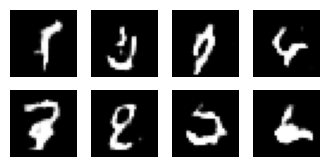

Time for epoch 91 is 12.761826038360596 sec
Epoch 90, Average Discriminator Loss: 0.2566802203655243, Average Generator Loss: 0.49670955538749695


2024-10-04 15:48:42.374230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 92 is 12.710062742233276 sec
Epoch 91, Average Discriminator Loss: 0.2548375427722931, Average Generator Loss: 0.49961188435554504


2024-10-04 15:48:55.076134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 93 is 12.699480772018433 sec
Epoch 92, Average Discriminator Loss: 0.253942608833313, Average Generator Loss: 0.5008873343467712


2024-10-04 15:49:07.886673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 94 is 12.80778694152832 sec
Epoch 93, Average Discriminator Loss: 0.2573911249637604, Average Generator Loss: 0.4970555007457733


2024-10-04 15:49:20.513400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 95 is 12.624330997467041 sec
Epoch 94, Average Discriminator Loss: 0.25825631618499756, Average Generator Loss: 0.4947485625743866


2024-10-04 15:49:33.532735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 96 is 13.01701283454895 sec
Epoch 95, Average Discriminator Loss: 0.2565385699272156, Average Generator Loss: 0.49804338812828064


2024-10-04 15:49:47.042271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 97 is 13.507492065429688 sec
Epoch 96, Average Discriminator Loss: 0.25502195954322815, Average Generator Loss: 0.49995237588882446


2024-10-04 15:50:00.686907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 98 is 13.642216205596924 sec
Epoch 97, Average Discriminator Loss: 0.2530331015586853, Average Generator Loss: 0.5004599690437317


2024-10-04 15:50:14.327181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 99 is 13.637539863586426 sec
Epoch 98, Average Discriminator Loss: 0.2515896260738373, Average Generator Loss: 0.5014990568161011
Time for epoch 100 is 13.775871992111206 sec
Epoch 99, Average Discriminator Loss: 0.2516975700855255, Average Generator Loss: 0.5008050203323364


2024-10-04 15:50:28.106551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


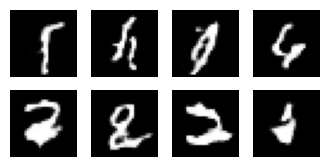

In [17]:
train(train_dataset, EPOCHS)

## Resultados
La red parece estar formando algo similar a los números, sin embargo estos todavía carecen de forma y definición. Todavía no se logra distinguir que números son. En algunas iteraciónes se alcancza a ver el 0, 5, y 9 de forma muy primitiva. Por el otro lado no se logran distinguir las imágenes. 

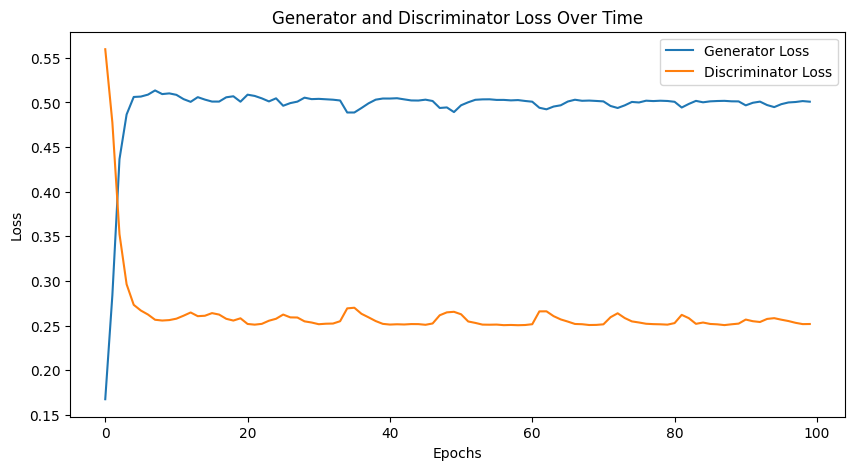

In [18]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(avg_gen_losses, label='Generator Loss')
plt.plot(avg_disc_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss Over Time')
plt.show()